# Optical Character Recognition In Python

This is a study of a topic that's been addressed many times


$\S 1:$ **Introduction: Optical Character Recognition**

OCR is a topic in machine learning that has been widely studied. Using a part of the (also well-known) [Char74](http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/) dataset, I develop multiple classifier models for street-view characters obtained from Google maps. 

This project is rather code-heavy, but if you're familiar with the way `scikit-learn` works it shouldn't require too much explanation. If you're not, feel free to reach out to me with questions/comments directly at derekjanni@gmail.com

For a basic roadmap of what's in this notebook:

1. Introduction 
2. Data Import & Cleaning
3. Evaluating Models by Score
4. Testing the model yourself!
5. First Attempt at HOG
6. Exporting Data as JSON for visualization

In [15]:
# sklearn models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import linear_model
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# wow even more sklearn stuff
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV

# sklearn metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split

# graphs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# images
from scipy.ndimage import convolve, rotate
from skimage.feature import hog
from skimage import draw, data, io, segmentation, color, exposure
from skimage.measure import regionprops
from skimage.filters import threshold_otsu
from skimage.transform import resize 
from skimage.transform import warp 
from PIL import Image

# basics
import pickle
import pandas as pd
import numpy as np
from pprint import pprint

$\S 2:$ **Importing and Cleaning the Data**

The data comes in as a folder of raw images, and a .csv with accompanying labels. The code below provides the following functionality:

- Import raw image by filename (needs to be .Bmp)
- Convert to Grayscale
- Use Otsu's Thresholding method to reduce noise
- Define "Nudging" to widen dataset and account for variance in signal location in image (used below on training data)
- Convert images to 1D np array of values

In the future, the following functionality should be added:

- Add Skewed images to training data
- Increase size of dataset

In [20]:
import math
import cv2

def img_round(x, base=75):
    """
    Now useless function (replaced by binarization) for flattening image data
    """
    return (base * math.floor(float(x)/base))
vround = np.vectorize(img_round) 

def get_img(i, size):
    """
    Returns a binary image from my file directory with index i
    """
    img = Image.open('/users/derekjanni/pyocr/train/'+ str(i+1) + '.Bmp')
    img = img.convert("L")
    img = img.resize((size,size))
    image = np.asarray(img)
    image.setflags(write=True)
    thresh = threshold_otsu(image)
    binary = image > thresh
    return binary

def nudge_dataset(X, Y, size):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the (size x size) images around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    shift = lambda x, w: convolve(x.reshape((size, size)), mode='constant',
                                  weights=w).ravel()
    #add nudged data
    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)

    return X, Y

def show_img(img):
    width = 5.0
    height = img.shape[0]*width/img.shape[1]
    f = plt.figure(figsize=(width, height))
    plt.imshow(img)

In [9]:
df = pd.read_csv('trainLabels.csv', header=0)
raw_y = np.asarray(df['Class'])
raw_x = np.asarray([get_img(i, 50) for i in df.index]).astype(float)
x = np.asarray([i.ravel() for i in raw_x])
y = raw_y
print x.shape, y.shape

(6283, 2500) (6283,)


In [34]:
# altered version for DNN data
df = pd.read_csv('trainLabels.csv', header=0)
raw_y = np.asarray(df['Class'])
raw_x = np.asarray([get_img(i, 50) for i in df.index]).astype(float)
x = np.asarray([i for i in raw_x])
Y = raw_y
X = x.reshape(-1, 1, 50, 50)
print x.shape, y.shape

X_train, X_test, Y_train, Y_test = X[:5000], X[5000:], Y[:5000], Y[5000:]

with open('char_data_cnn.pkl', 'w') as outfile:
    pickle.dump([X_train, Y_train, X_test, Y_test], outfile)

(6283, 50, 50) (6283,)


$\S 3:$ **Setting Up Some Models**

I've run just about every classifier algorithm known to man on this dataset, with varying results. I've limited the number of models that I run for sake of time: we'll be running a lot of images through this program, which means it takes a lot of time. Below are three of the best and most intuitive methods. A few notes:

- Bernoulli Naive Bayes is an intuitive solution as it expects binary data (which is what Otsu's method returns) to predict a binary outcome (either this string is or is not the letter "A", for instance). This method doesn't abuse nudging as well as its counterparts, as we'll see below.

- If you disable the line below that performs the "nudging" you'll see that performance of KNN and Random Forest decreases rather dramatically! That's pretty interesting, but it should be intuitive why nudging in directions is effective!

A necessary improvement is to account for skew in input images, or to naturally deskew them upon entering them.

In [30]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y)

#nudge dataset improves performance: test and see!
X_train, Y_train = nudge_dataset(X_train, Y_train, 50)

with open('char_data.pkl', 'w') as outfile:
    pickle.dump([X_train, Y_train, X_test, Y_test], outfile)

In [24]:
def precision_report(model):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    return classification_report(Y_test, Y_pred)

# declare models for explicit-ness
models = {'Gradient Boosting Classifier': GradientBoostingClassifier(n_estimators=50)
          #'Random Forest Classifier': RandomForestClassifier()
         }

print X_train.shape, Y_train.shape
for i in models:
    print i + ':\n' + str(precision_report(models[i]))

(23560, 2500) (23560,)
Gradient Boosting Classifier:
             precision    recall  f1-score   support

          0       0.14      0.04      0.06        26
          1       0.40      0.25      0.31        16
          2       0.64      0.47      0.54        15
          3       0.50      0.33      0.40         6
          4       0.75      0.38      0.50         8
          5       0.00      0.00      0.00        12
          6       0.75      0.20      0.32        15
          7       0.50      0.12      0.20         8
          8       0.00      0.00      0.00         5
          9       0.00      0.00      0.00         9
          A       0.59      0.85      0.69       112
          B       0.40      0.17      0.24        24
          C       0.44      0.71      0.54        31
          D       0.35      0.43      0.38        35
          E       0.57      0.84      0.68        93
          F       0.67      0.35      0.46        17
          G       0.53      0.31      0.39   

So we see that KNN and Random Forest are our best predictors, on the whole. Lets see their accuracy scores as opposed to precision/recall, to get a feel for their actual performance


In [19]:
def accuracy_report(model):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    return accuracy_score(Y_test, Y_pred)

for i in models:
    print i + ':\n' + str(accuracy_report(models[i]))

Bernoulli Naive Bayes:
0.0477402928071
(5) K-Nearest Neighbors:
0.558243157225
Random Forest Classifier:
0.532781667728


To make my own life easier, I pickled the models here to pull them up later

In [20]:
# models
knn = KNeighborsClassifier(n_neighbors=5)
rfc = RandomForestClassifier()
bnb = BernoulliNB()

# fit
knn.fit(X_train, Y_train)
rfc.fit(X_train, Y_train)
bnb.fit(X_train, Y_train)

# pickle
with open('knn.pkl', 'w') as picklefile:
    pickle.dump(knn, picklefile)
with open('rfc.pkl', 'w') as picklefile:
    pickle.dump(rfc, picklefile)
with open('bnb.pkl', 'w') as picklefile:
    pickle.dump(bnb, picklefile)

KNN is an interesting (and intuitive) solution to this problem, given the nudging technique. Lets see how the algorithm performs for varying K.

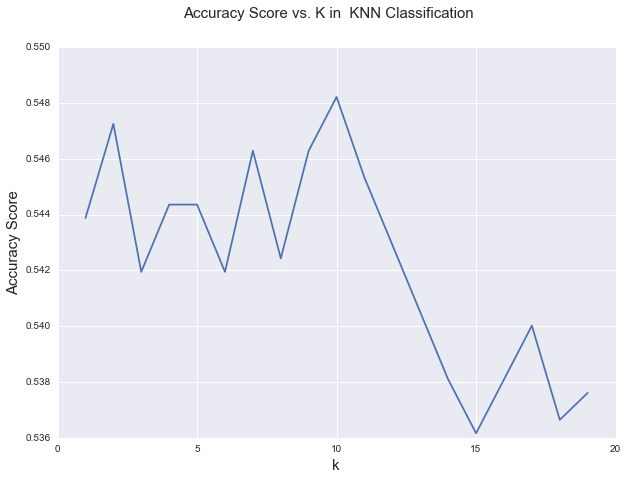

In [21]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=42)

#nudge dataset improves performance: test and see!
X_train, Y_train = nudge_dataset(X_train, Y_train, 50)

def accuracy_knn(k):
    neighbors = KNeighborsClassifier(n_neighbors=k)
    neighbors.fit(X_train, Y_train)
    return accuracy_score(Y_test, neighbors.predict(X_test))

k = [i for i in range(1, 20)]
acc_knn = [accuracy_knn(i) for i in range(1, 20)]
plt.figure(figsize=(10,7)).suptitle("Accuracy Score vs. K in  KNN Classification", fontsize='15')
plt.xlabel('k', fontsize='15')
plt.ylabel('Accuracy Score', fontsize='15')
plt.plot(k, acc_knn)

$\S 4:$ **Testing the models with real images**

Sometimes seeing really is believing, and it's fun to see how models perform on data for yourself! Use the code below to generate a random image and evaluate the computer's effectiveness at this task, as well as notice where it goes wrong.


In [22]:
with open('knn.pkl') as picklefile:
    knn = pickle.load(picklefile)
with open('rfc.pkl') as picklefile:
    rfc = pickle.load(picklefile)

In [23]:
def get_test_img(i):
    """
    Returns image from my file directory with corresponding index i
    """
    img = Image.open('/users/derekjanni/pyocr/test/'+ str(i) + '.Bmp')
    img = img.convert("L")
    img = img.resize((50,50))
    image = np.asarray(img)
    image.setflags(write=True)
    thresh = threshold_otsu(image)
    binary = image > thresh
    return binary

My Guess for this file is:I


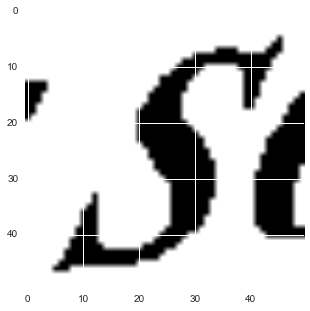

In [24]:
from random import randint

random_image = randint(6284, 12503)
print("My Guess for this file is:" + str(knn.predict(get_test_img(random_image).ravel())).strip('[]\''))
show_img(get_test_img(random_image))

The code below writes a submission for the relevant Kaggle competition. As of 8/5/2015 my model is among the top 10!

In [25]:
with open('submission2.csv', 'w') as outfile:
    outfile.write('ID,Class\n')
    for i in range(6284, 12504):
        pre = str(rfc.predict(get_test_img(i).ravel())).strip('[]\'')
        outfile.write(str(i) + ','+ pre +'\n')

$\S 5:$ **Histogram of Oriented Gradients as a feature matrix**


It might look like I've done really well here, however, part of this is cooked up: Since the images are nudged, there is a lot of overlap and repetitive labeling going on. What would be more interesting is if a HOG approach could better define letters! Lets see how KNN, RFC and LinearSVC perform on a Histogram of Oriented Gradients!

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV


def get_hog(img):
    fd, hog_image = hog(img, orientations=10, pixels_per_cell=(5, 5), cells_per_block=(2, 2), visualise=True)
    return exposure.rescale_intensity(hog_image, in_range=(0, 0.9))
    
def get_img_hog(i, size):
    """
    Returns a binary image from my file directory with index i
    """
    img = Image.open('/users/derekjanni/pyocr/train/'+ str(i+1) + '.Bmp')
    img = img.convert("L")
    img = img.resize((size,size))
    image = np.asarray(img)
    image.setflags(write=True)
    thresh = threshold_otsu(image)
    binary = image > thresh
    return get_hog(binary)

df = pd.read_csv('trainLabels.csv', header=0)
raw_y = np.asarray(df['Class'])
raw_x = np.asarray([get_img_hog(i, 50) for i in df.index]).astype(float)
x = np.asarray([i.ravel() for i in raw_x])
y = raw_y

In [18]:
# Standard Scaler
ss = StandardScaler()
x = ss.fit_transform(x)

# PCA
pca = PCA(n_components=1000)
x = pca.fit_transform(x)

In [19]:
# params
params_to_try = {
    'C': [10**i for i in range(0, 2)],
    'gamma': [10**i for i in range(-7, -5)],
}

# Grid Search
gs = GridSearchCV(SVC(class_weight='auto', kernel='rbf', probability=True),
                  param_grid=params_to_try,
                  cv=3,
                  scoring='roc_auc',
                  n_jobs=4)

from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=.2, random_state=42)

#nudge dataset improves performance: test and see!
# X_train, Y_train = nudge_dataset(X_train, Y_train, 50)

In [20]:
# results
gs.fit(X_train, Y_train)
print "Best score:", gs.best_score_

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
    ...........................................................................
//anaconda/lib/python2.7/runpy.py in _run_module_as_main(mod_name='IPython.kernel.__main__', alter_argv=1)
    157     pkg_name = mod_name.rpartition('.')[0]
    158     main_globals = sys.modules["__main__"].__dict__
    159     if alter_argv:
    160         sys.argv[0] = fname
    161     return _run_code(code, main_globals, None,
--> 162                      "__main__", fname, loader, pkg_name)
        fname = '/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = 'IPython.kernel'
    163 
    164 def run_module(mod_name, init_globals=None,
    165                run_name=None, alter_sys=False):
    166     """Execute a module's code without importing it

...........................................................................
//anaconda/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x10564c7b0, file "/ana...ite-packages/IPython/kernel/__main__.py", line 1>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'IPython.kernel', 'app': <module 'IPython.kernel.zmq.kernelapp' from '//a.../site-packages/IPython/kernel/zmq/kernelapp.pyc'>}, init_globals=None, mod_name='__main__', mod_fname='/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='IPython.kernel')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x10564c7b0, file "/ana...ite-packages/IPython/kernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'IPython.kernel', 'app': <module 'IPython.kernel.zmq.kernelapp' from '//a.../site-packages/IPython/kernel/zmq/kernelapp.pyc'>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from IPython.kernel.zmq import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
//anaconda/lib/python2.7/site-packages/IPython/config/application.py in launch_instance(cls=<class 'IPython.kernel.zmq.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    569         
    570         If a global instance already exists, this reinitializes and starts it
    571         """
    572         app = cls.instance(**kwargs)
    573         app.initialize(argv)
--> 574         app.start()
        app.start = <bound method IPKernelApp.start of <IPython.kernel.zmq.kernelapp.IPKernelApp object>>
    575 
    576 #-----------------------------------------------------------------------------
    577 # utility functions, for convenience
    578 #-----------------------------------------------------------------------------

...........................................................................
//anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelapp.py in start(self=<IPython.kernel.zmq.kernelapp.IPKernelApp object>)
    368     def start(self):
    369         if self.poller is not None:
    370             self.poller.start()
    371         self.kernel.start()
    372         try:
--> 373             ioloop.IOLoop.instance().start()
    374         except KeyboardInterrupt:
    375             pass
    376 
    377 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
//anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    146             PollIOLoop.configure(ZMQIOLoop)
    147         return PollIOLoop.instance()
    148     
    149     def start(self):
    150         try:
--> 151             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    152         except ZMQError as e:
    153             if e.errno == ETERM:
    154                 # quietly return on ETERM
    155                 pass

...........................................................................
//anaconda/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    861                 self._events.update(event_pairs)
    862                 while self._events:
    863                     fd, events = self._events.popitem()
    864                     try:
    865                         fd_obj, handler_func = self._handlers[fd]
--> 866                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    867                     except (OSError, IOError) as e:
    868                         if errno_from_exception(e) == errno.EPIPE:
    869                             # Happens when the client closes the connection
    870                             pass

...........................................................................
//anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
//anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    428             # dispatch events:
    429             if events & IOLoop.ERROR:
    430                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    431                 return
    432             if events & IOLoop.READ:
--> 433                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    434                 if not self.socket:
    435                     return
    436             if events & IOLoop.WRITE:
    437                 self._handle_send()

...........................................................................
//anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    460                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    461         else:
    462             if self._recv_callback:
    463                 callback = self._recv_callback
    464                 # self._recv_callback = None
--> 465                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    466                 
    467         # self.update_state()
    468         
    469 

...........................................................................
//anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    402         close our socket."""
    403         try:
    404             # Use a NullContext to ensure that all StackContexts are run
    405             # inside our blanket exception handler rather than outside.
    406             with stack_context.NullContext():
--> 407                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    408         except:
    409             gen_log.error("Uncaught exception, closing connection.",
    410                           exc_info=True)
    411             # Close the socket on an uncaught exception from a user callback

...........................................................................
//anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
//anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    247         if self.control_stream:
    248             self.control_stream.on_recv(self.dispatch_control, copy=False)
    249 
    250         def make_dispatcher(stream):
    251             def dispatcher(msg):
--> 252                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    253             return dispatcher
    254 
    255         for s in self.shell_streams:
    256             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
//anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py in dispatch_shell(self=<IPython.kernel.zmq.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'# results\ngs.fit(X_train, Y_train)\nprint "Best score:", gs.best_score_', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'msg_id': u'34C4DD44729040FD8DC2BF24CFE0BEAD', u'msg_type': u'execute_request', u'session': u'40AF67ED4B544A858F0517937D371536', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'34C4DD44729040FD8DC2BF24CFE0BEAD', 'msg_type': u'execute_request', 'parent_header': {}})
    208         else:
    209             # ensure default_int_handler during handler call
    210             sig = signal(SIGINT, default_int_handler)
    211             self.log.debug("%s: %s", msg_type, msg)
    212             try:
--> 213                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <IPython.kernel.zmq.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['40AF67ED4B544A858F0517937D371536']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u'# results\ngs.fit(X_train, Y_train)\nprint "Best score:", gs.best_score_', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'msg_id': u'34C4DD44729040FD8DC2BF24CFE0BEAD', u'msg_type': u'execute_request', u'session': u'40AF67ED4B544A858F0517937D371536', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'34C4DD44729040FD8DC2BF24CFE0BEAD', 'msg_type': u'execute_request', 'parent_header': {}}
    214             except Exception:
    215                 self.log.error("Exception in message handler:", exc_info=True)
    216             finally:
    217                 signal(SIGINT, sig)

...........................................................................
//anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py in execute_request(self=<IPython.kernel.zmq.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['40AF67ED4B544A858F0517937D371536'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'# results\ngs.fit(X_train, Y_train)\nprint "Best score:", gs.best_score_', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'msg_id': u'34C4DD44729040FD8DC2BF24CFE0BEAD', u'msg_type': u'execute_request', u'session': u'40AF67ED4B544A858F0517937D371536', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'34C4DD44729040FD8DC2BF24CFE0BEAD', 'msg_type': u'execute_request', 'parent_header': {}})
    357         if not silent:
    358             self.execution_count += 1
    359             self._publish_execute_input(code, parent, self.execution_count)
    360         
    361         reply_content = self.do_execute(code, silent, store_history,
--> 362                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    363 
    364         # Flush output before sending the reply.
    365         sys.stdout.flush()
    366         sys.stderr.flush()

...........................................................................
//anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/ipkernel.py in do_execute(self=<IPython.kernel.zmq.ipkernel.IPythonKernel object>, code=u'# results\ngs.fit(X_train, Y_train)\nprint "Best score:", gs.best_score_', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    176 
    177         reply_content = {}
    178         # FIXME: the shell calls the exception handler itself.
    179         shell._reply_content = None
    180         try:
--> 181             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <I....kernel.zmq.zmqshell.ZMQInteractiveShell object>>
        code = u'# results\ngs.fit(X_train, Y_train)\nprint "Best score:", gs.best_score_'
        store_history = True
        silent = False
    182         except:
    183             status = u'error'
    184             # FIXME: this code right now isn't being used yet by default,
    185             # because the run_cell() call above directly fires off exception

...........................................................................
//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<IPython.kernel.zmq.zmqshell.ZMQInteractiveShell object>, raw_cell=u'# results\ngs.fit(X_train, Y_train)\nprint "Best score:", gs.best_score_', store_history=True, silent=False, shell_futures=True)
   2866                 self.displayhook.exec_result = result
   2867 
   2868                 # Execute the user code
   2869                 interactivity = "none" if silent else self.ast_node_interactivity
   2870                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2871                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2872 
   2873                 # Reset this so later displayed values do not modify the
   2874                 # ExecutionResult
   2875                 self.displayhook.exec_result = None

...........................................................................
//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<IPython.kernel.zmq.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>, <_ast.Print object>], cell_name='<ipython-input-20-1c58da248980>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2970 
   2971         try:
   2972             for i, node in enumerate(to_run_exec):
   2973                 mod = ast.Module([node])
   2974                 code = compiler(mod, cell_name, "exec")
-> 2975                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <I....kernel.zmq.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x104452f30, file "<ipython-input-20-1c58da248980>", line 2>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   2976                     return True
   2977 
   2978             for i, node in enumerate(to_run_interactive):
   2979                 mod = ast.Interactive([node])

...........................................................................
//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<IPython.kernel.zmq.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x104452f30, file "<ipython-input-20-1c58da248980>", line 2>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   3030         outflag = 1  # happens in more places, so it's easier as default
   3031         try:
   3032             try:
   3033                 self.hooks.pre_run_code_hook()
   3034                 #rprint('Running code', repr(code_obj)) # dbg
-> 3035                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x104452f30, file "<ipython-input-20-1c58da248980>", line 2>
        self.user_global_ns = {'BernoulliNB': <class 'sklearn.naive_bayes.BernoulliNB'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'GridSearchCV': <class 'sklearn.grid_search.GridSearchCV'>, 'Image': <module 'PIL.Image' from '//anaconda/lib/python2.7/site-packages/PIL/Image.pyc'>, 'In': ['', u'from sklearn.preprocessing import StandardScal...':\\n\' + str(precision_report(models[i]))\'\'\'', u"# sklearn models\nfrom sklearn.neighbors impor...d\nimport numpy as np\nfrom pprint import pprint", u'from sklearn.preprocessing import StandardScal...':\\n\' + str(precision_report(models[i]))\'\'\'', u'from sklearn.preprocessing import StandardScal...':\\n\' + str(precision_report(models[i]))\'\'\'', u'from sklearn.preprocessing import StandardScal...':\\n\' + str(precision_report(models[i]))\'\'\'', u'from sklearn.preprocessing import StandardScal...':\\n\' + str(precision_report(models[i]))\'\'\'', u'import math\nimport cv2\n\ndef img_round(x, ba...re(figsize=(width, height))\n    plt.imshow(img)', u'from sklearn.preprocessing import StandardScal...':\\n\' + str(precision_report(models[i]))\'\'\'', u'from sklearn.preprocessing import StandardScal...':\\n\' + str(precision_report(models[i]))\'\'\'', u'from sklearn.preprocessing import StandardScal...':\\n\' + str(precision_report(models[i]))\'\'\'', u'from sklearn.preprocessing import StandardScal...p.asarray([i.ravel() for i in raw_x])\ny = raw_y', u'# Standard Scaler\nss = StandardScaler()\nx = ...PCA(n_components=1000)\nx = pca.fit_transform(x)', u"# params\nparams_to_try = {\n    'C': [10**i f...n, Y_train = nudge_dataset(X_train, Y_train, 50)", u'# results\ngs.fit(X_train, Y_train)\nprint "Be...':\\n\' + str(precision_report(models[i]))\'\'\'', u"# sklearn models\nfrom sklearn.neighbors impor...d\nimport numpy as np\nfrom pprint import pprint", u"# sklearn models\nfrom sklearn.neighbors impor...d\nimport numpy as np\nfrom pprint import pprint", u'from sklearn.preprocessing import StandardScal...p.asarray([i.ravel() for i in raw_x])\ny = raw_y', u'# Standard Scaler\nss = StandardScaler()\nx = ...PCA(n_components=1000)\nx = pca.fit_transform(x)', u"# params\nparams_to_try = {\n    'C': [10**i f...n, Y_train = nudge_dataset(X_train, Y_train, 50)", ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'Out': {}, ...}
        self.user_ns = {'BernoulliNB': <class 'sklearn.naive_bayes.BernoulliNB'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'GridSearchCV': <class 'sklearn.grid_search.GridSearchCV'>, 'Image': <module 'PIL.Image' from '//anaconda/lib/python2.7/site-packages/PIL/Image.pyc'>, 'In': ['', u'from sklearn.preprocessing import StandardScal...':\\n\' + str(precision_report(models[i]))\'\'\'', u"# sklearn models\nfrom sklearn.neighbors impor...d\nimport numpy as np\nfrom pprint import pprint", u'from sklearn.preprocessing import StandardScal...':\\n\' + str(precision_report(models[i]))\'\'\'', u'from sklearn.preprocessing import StandardScal...':\\n\' + str(precision_report(models[i]))\'\'\'', u'from sklearn.preprocessing import StandardScal...':\\n\' + str(precision_report(models[i]))\'\'\'', u'from sklearn.preprocessing import StandardScal...':\\n\' + str(precision_report(models[i]))\'\'\'', u'import math\nimport cv2\n\ndef img_round(x, ba...re(figsize=(width, height))\n    plt.imshow(img)', u'from sklearn.preprocessing import StandardScal...':\\n\' + str(precision_report(models[i]))\'\'\'', u'from sklearn.preprocessing import StandardScal...':\\n\' + str(precision_report(models[i]))\'\'\'', u'from sklearn.preprocessing import StandardScal...':\\n\' + str(precision_report(models[i]))\'\'\'', u'from sklearn.preprocessing import StandardScal...p.asarray([i.ravel() for i in raw_x])\ny = raw_y', u'# Standard Scaler\nss = StandardScaler()\nx = ...PCA(n_components=1000)\nx = pca.fit_transform(x)', u"# params\nparams_to_try = {\n    'C': [10**i f...n, Y_train = nudge_dataset(X_train, Y_train, 50)", u'# results\ngs.fit(X_train, Y_train)\nprint "Be...':\\n\' + str(precision_report(models[i]))\'\'\'', u"# sklearn models\nfrom sklearn.neighbors impor...d\nimport numpy as np\nfrom pprint import pprint", u"# sklearn models\nfrom sklearn.neighbors impor...d\nimport numpy as np\nfrom pprint import pprint", u'from sklearn.preprocessing import StandardScal...p.asarray([i.ravel() for i in raw_x])\ny = raw_y', u'# Standard Scaler\nss = StandardScaler()\nx = ...PCA(n_components=1000)\nx = pca.fit_transform(x)', u"# params\nparams_to_try = {\n    'C': [10**i f...n, Y_train = nudge_dataset(X_train, Y_train, 50)", ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'Out': {}, ...}
   3036             finally:
   3037                 # Reset our crash handler in place
   3038                 sys.excepthook = old_excepthook
   3039         except SystemExit as e:

...........................................................................
/Users/derekjanni/PyOCR/<ipython-input-20-1c58da248980> in <module>()
      1 
----> 2 
      3 
      4 
      5 # results
      6 gs.fit(X_train, Y_train)
      7 print "Best score:", gs.best_score_
      8 
      9 
     10 

...........................................................................
//anaconda/lib/python2.7/site-packages/sklearn/grid_search.py in fit(self=GridSearchCV(cv=3, error_score='raise',
       e...e_func=None,
       scoring='roc_auc', verbose=0), X=array([[ -4.76116885e+00,   4.75162781e+00,  -2....883263e-16,   4.69638395e-16,   3.67009761e-16]]), y=array(['L', 'e', 'B', ..., 'v', 'J', 'R'], dtype=object))
    727         y : array-like, shape = [n_samples] or [n_samples, n_output], optional
    728             Target relative to X for classification or regression;
    729             None for unsupervised learning.
    730 
    731         """
--> 732         return self._fit(X, y, ParameterGrid(self.param_grid))
        self._fit = <bound method GridSearchCV._fit of GridSearchCV(..._func=None,
       scoring='roc_auc', verbose=0)>
        X = array([[ -4.76116885e+00,   4.75162781e+00,  -2....883263e-16,   4.69638395e-16,   3.67009761e-16]])
        y = array(['L', 'e', 'B', ..., 'v', 'J', 'R'], dtype=object)
        self.param_grid = {'C': [1, 10], 'gamma': [1e-07, 1e-06]}
    733 
    734 
    735 class RandomizedSearchCV(BaseSearchCV):
    736     """Randomized search on hyper parameters.

...........................................................................
//anaconda/lib/python2.7/site-packages/sklearn/grid_search.py in _fit(self=GridSearchCV(cv=3, error_score='raise',
       e...e_func=None,
       scoring='roc_auc', verbose=0), X=array([[ -4.76116885e+00,   4.75162781e+00,  -2....883263e-16,   4.69638395e-16,   3.67009761e-16]]), y=array(['L', 'e', 'B', ..., 'v', 'J', 'R'], dtype=object), parameter_iterable=<sklearn.grid_search.ParameterGrid object>)
    500         )(
    501             delayed(_fit_and_score)(clone(base_estimator), X, y, self.scorer_,
    502                                     train, test, self.verbose, parameters,
    503                                     self.fit_params, return_parameters=True,
    504                                     error_score=self.error_score)
--> 505                 for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.grid_search.ParameterGrid object>
    506                 for train, test in cv)
    507 
    508         # Out is a list of triplet: score, estimator, n_test_samples
    509         n_fits = len(out)

...........................................................................
//anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<itertools.islice object>)
    661             if pre_dispatch == "all" or n_jobs == 1:
    662                 # The iterable was consumed all at once by the above for loop.
    663                 # No need to wait for async callbacks to trigger to
    664                 # consumption.
    665                 self._iterating = False
--> 666             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    667             # Make sure that we get a last message telling us we are done
    668             elapsed_time = time.time() - self._start_time
    669             self._print('Done %3i out of %3i | elapsed: %s finished',
    670                         (len(self._output),

    ---------------------------------------------------------------------------
    Sub-process traceback:
    ---------------------------------------------------------------------------
    ValueError                                         Mon Aug 24 11:13:31 2015
PID: 6842                              Python 2.7.10: //anaconda/bin/python
...........................................................................
//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.pyc in _fit_and_score(estimator=SVC(C=1, cache_size=200, class_weight='auto', co...e=None, shrinking=True, tol=0.001, verbose=False), X=array([[ -4.76116885e+00,   4.75162781e+00,  -2....883263e-16,   4.69638395e-16,   3.67009761e-16]]), y=array(['L', 'e', 'B', ..., 'v', 'J', 'R'], dtype=object), scorer=make_scorer(roc_auc_score, needs_threshold=True), train=array([ 932,  978, 1109, ..., 5023, 5024, 5025]), test=array([   0,    1,    2, ..., 2310, 2319, 2473]), verbose=0, parameters={'C': 1, 'gamma': 1e-07}, fit_params={}, return_train_score=False, return_parameters=True, error_score='raise')
   1473                              " numeric value. (Hint: if using 'raise', please"
   1474                              " make sure that it has been spelled correctly.)"
   1475                              )
   1476 
   1477     else:
-> 1478         test_score = _score(estimator, X_test, y_test, scorer)
   1479         if return_train_score:
   1480             train_score = _score(estimator, X_train, y_train, scorer)
   1481 
   1482     scoring_time = time.time() - start_time

...........................................................................
//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.pyc in _score(estimator=SVC(C=1, cache_size=200, class_weight='auto', co...e=None, shrinking=True, tol=0.001, verbose=False), X_test=array([[ -4.76116885e+00,   4.75162781e+00,  -2....541808e-16,   5.25932293e-16,   5.11952836e-16]]), y_test=array(['L', 'e', 'B', ..., 'p', 'x', '2'], dtype=object), scorer=make_scorer(roc_auc_score, needs_threshold=True))
   1529 def _score(estimator, X_test, y_test, scorer):
   1530     """Compute the score of an estimator on a given test set."""
   1531     if y_test is None:
   1532         score = scorer(estimator, X_test)
   1533     else:
-> 1534         score = scorer(estimator, X_test, y_test)
   1535     if not isinstance(score, numbers.Number):
   1536         raise ValueError("scoring must return a number, got %s (%s) instead."
   1537                          % (str(score), type(score)))
   1538     return score

...........................................................................
//anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.pyc in __call__(self=make_scorer(roc_auc_score, needs_threshold=True), clf=SVC(C=1, cache_size=200, class_weight='auto', co...e=None, shrinking=True, tol=0.001, verbose=False), X=array([[ -4.76116885e+00,   4.75162781e+00,  -2....541808e-16,   5.25932293e-16,   5.11952836e-16]]), y=array(['L', 'e', 'B', ..., 'p', 'x', '2'], dtype=object), sample_weight=None)
    153         score : float
    154             Score function applied to prediction of estimator on X.
    155         """
    156         y_type = type_of_target(y)
    157         if y_type not in ("binary", "multilabel-indicator"):
--> 158             raise ValueError("{0} format is not supported".format(y_type))
    159 
    160         try:
    161             y_pred = clf.decision_function(X)
    162 

ValueError: multiclass format is not supported
___________________________________________________________________________

In [ ]:
def precision_report(model):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    return classification_report(Y_test, Y_pred)

for i in models:
    print i + ':\n' + str(precision_report(models[i]))

Again, the accuracy scores are of interest

In [31]:
for i in models:
    print i + ':\n' + str(accuracy_report(models[i]))

Bernoulli Naive Bayes:
0.222151495863
(5) K-Nearest Neighbors:
0.50732017823
Random Forest Classifier:
0.301718650541


$\S 6:$ **Sending the data to JSON for visualization**
    
In my opinion, the confusion matrix for this problem is one of the most interesting visuals I can generate! It's a great summary of where the KNN model fails and might help show *why* it fails as well.


In [ ]:
with open('knn.pkl') as picklefile:
    knn = pickle.load(picklefile)

#test/train split    
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=42)

#nudge dataset improves performance: test and see!
X_train, Y_train = nudge_dataset(X_train, Y_train, 50)

knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)

In [ ]:
#normalize confusion matrix
from scipy.stats import zscore
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
print cm.shape

In [ ]:
columns = ["0",
        "1",
        "2",
        "3",
        "4", 
        "5", 
        "6", 
        "7", 
        "8", 
        "9", 
        "A",
        "B", 
        "C", 
        "D", 
        "E", 
        "F", 
        "G", 
        "H", 
        "I", 
        "J", 
        "K", 
        "L",
        "M",
        "N", 
        "O", 
        "P", 
        "Q", 
        "R", 
        "S", 
        "T", 
        "U", 
        "V", 
        "W", 
        "X",
        "Y",
        "Z", 
        "a", 
        "b", 
        "c", 
        "d", 
        "e", 
        "f", 
        "g", 
        "h", 
        "i", 
        "j",
        "k",
        "l",
        "m",
        "n",
        "o",
        "p",
        "q", 
        "r",
        "s",
        "t",
        "u",
        "v",
        "w",
        "x",
        "y",
        "z"
        ];

In [ ]:
rows = ["0",
        "1",
        "2",
        "3",
        "4", 
        "5", 
        "6", 
        "7", 
        "8", 
        "9", 
        "A",
        "B", 
        "C", 
        "D", 
        "E", 
        "F", 
        "G", 
        "H", 
        "I", 
        "J", 
        "K", 
        "L",
        "M",
        "N", 
        "O", 
        "P", 
        "Q", 
        "R", 
        "S", 
        "T", 
        "U", 
        "V", 
        "W", 
        "X",
        "Y",
        "Z", 
        "a", 
        "b", 
        "c", 
        "d", 
        "e", 
        "f", 
        "g", 
        "h", 
        "i", 
        "j",
        "k",
        "l",
        "m",
        "n",
        "o",
        "p",
        "q", 
        "r",
        "s",
        "t",
        "u",
        "v",
        "w",
        "x",
        "y",
        "z"
        ];

In [ ]:
data = list(list(i) for i in cm)

In [ ]:
knn_data = {
    "columns": [list(["R", i]) for i  in columns],
    "index": [list(i) for i in rows],
    "data": data,
}

knn_numbers = {
    "columns": [list(["R", i]) for i  in columns[:10]],
    "index": [list(i) for i in rows[:10]],
    "data": [i[:10] for i in data[:10]],
}

knn_caps = {
    "columns": [list(["R", i]) for i  in columns[10:36]],
    "index": [list(i) for i in rows[10:36]],
    "data": [i[10:36] for i in data[10:36]],
}

knn_lower = {
    "columns": [list(["R", i]) for i  in columns[36:]],
    "index": [list(i) for i in rows[36:]],
    "data": [i[36:] for i in data[36:]],
}


In [ ]:
import json

with open('knn_data.json', 'w') as outfile:
    json.dump(knn_data, outfile)

with open('knn_numbers.json', 'w') as outfile:
    json.dump(knn_numbers, outfile)
      
with open('knn_caps.json', 'w') as outfile:
    json.dump(knn_caps, outfile)

with open('knn_lower.json', 'w') as outfile:
    json.dump(knn_lower, outfile)

In [47]:
def get_img(i, size):
    """
    Returns a binary image from my file directory with index i
    """
    img = Image.open('/users/derekjanni/pyocr/train/'+ str(i+1) + '.Bmp')
    img = img.convert("L")
    img = img.resize((size,size))
    image = np.asarray(img)
    image.setflags(write=True)
    thresh = threshold_otsu(image)
    binary = image > thresh
    return binary

def nudge_dataset(X, Y, size):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the (size x size) images around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    shift = lambda x, w: convolve(x.reshape((size, size)), mode='constant',
                                  weights=w).ravel()
    #add nudged data
    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    #add warps
    Y_pre_warp = Y
    X_pre_warp = X
    for i in range(-30, 31, 15):
        M = cv2.getRotationMatrix2D((size,size),i,1)
        X = np.concatenate([X] + [np.asarray([cv2.warpAffine(x_, M, (size,size)).ravel() for x_ in X_pre_warp])])
        Y = np.concatenate((Y, Y_pre_warp), axis=0)
    return X, Y


X1 = np.asarray([get_img(i, 50).ravel() for i in range(1, 4)]).astype(float)
Y1 = np.asarray(['n' for i in range(len(X1))])
print X1.shape, Y1.shape
newx, newy = nudge_dataset(X1, Y1, 50)
print newx.shape, newy.shape

def show_img(img):
    width = 5.0
    height = img.shape[0]*width/img.shape[1]
    f = plt.figure(figsize=(width, height))
    plt.imshow(img)

(3, 2500) (3,)
(90, 2500) (90,)
